# Training a Recurrent Neural Network

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload

## Import Tensorflow and Numpy for Model training and interacting with data

In [1]:
import tensorflow as tf
import numpy as np

## Import self written Utils for visualizing data

In [3]:
from utils import *

## Import file with model definitions and functions needed to train them

In [4]:
from models import get_model_dict
from train_models import *

## Define Constants

In [5]:
time_steps = 50

test_fraction = 0.2
validation_fraction = 0.2

learning_rate = 1e-3
decay = 0.001
max_epochs = 50
patience = 10
batch_size = 2000

In [6]:
sensors = get_sensor_names()

num_input = len(sensors)

sensors

['co2Indoor',
 'humidityIndoor',
 'humidityOutdoor',
 'temperatureIndoor',
 'temperatureOutdoor']

## Create Datasets
### Load all available data

In [7]:
X, Y = get_data(time_steps, sensors)

### Scale Features

In [8]:
X_scaled, min_X, max_X = scale_data(X) #min_X and max_X are needed when making new predictions for consistent scaling

### Split data into training, validation and test datasets

In [9]:
X_train, Y_train, X_val, Y_val, X_test, Y_test = split_data(X_scaled, Y, test_fraction, validation_fraction, 3)
(X_train.shape, Y_train.shape), (X_val.shape, Y_val.shape), (X_test.shape, Y_test.shape)

(((32813, 50, 5), (32813,)),
 ((10941, 50, 5), (10941,)),
 ((10938, 50, 5), (10938,)))

In [10]:
neg, pos = np.bincount(Y.astype(int))
pos / Y.shape[0]

0.2068492649747678

## Load Model definitions as a name-model dictionary

In [11]:
model_dict = get_model_dict(num_input, time_steps)

## Calculate Class-Weights for model training

In [12]:
weight_for_neg = (1 / neg)*(Y.shape[0])/2.0
weight_for_pos = (1 / pos)*(Y.shape[0])/2.0

class_weight = {0: weight_for_neg, 1: weight_for_pos}
class_weight

{0: 0.630397196800295, 1: 2.417219128436312}

## Klassenverteilung überprüfen

In [13]:
np.bincount(Y_train.astype(int)), np.bincount(Y_val.astype(int)), np.bincount(Y_test.astype(int))

(array([26168,  6645]), array([8120, 2821]), array([9091, 1847]))

## Train all the models

In [15]:
histories = train_models(model_dict, (X_train, Y_train), (X_val, Y_val), learning_rate, decay, max_epochs, batch_size, patience, class_weight)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                11200     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 20)                1020      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 12,241
Trainable params: 12,241
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.6141,  auc:0.6526,  binary_crossentropy:0.6748,  fn:2792.0000,  fp:9870.0000,  loss:0.6734,  pre

## Plot the progression of metrics for each model

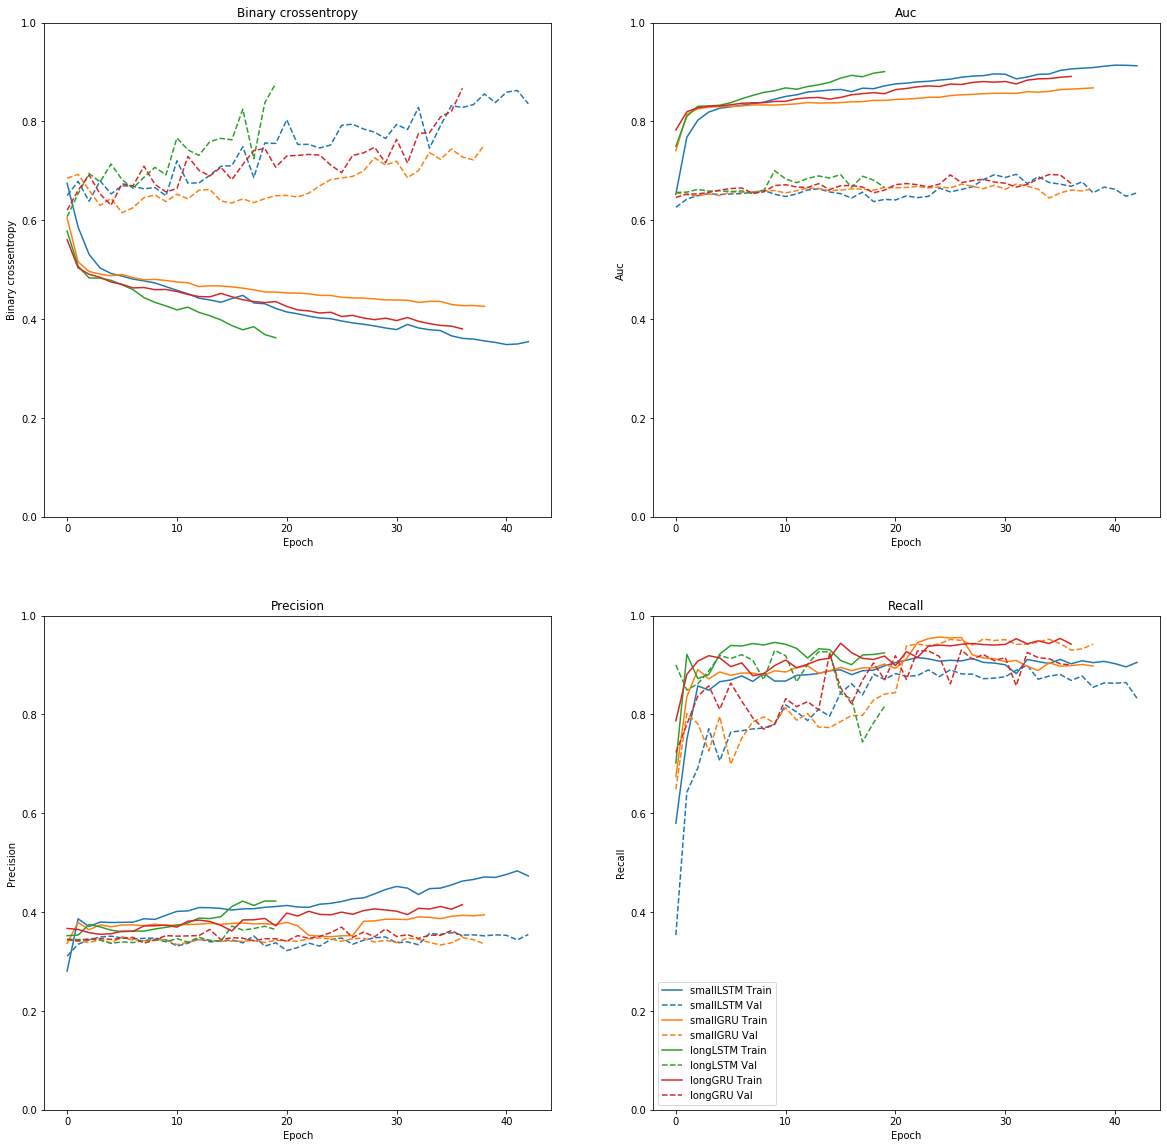

In [16]:
plot_metrics(histories)

## Evalueate the best Model, as seen on the plots, using the test dataset

In [17]:
model_dict['smallGRU'].evaluate(X_test, Y_test, batch_size=batch_size)

10938/10938 [==============================] - 0s 4us/sample - loss: 0.6960 - tp: 1482.0000 - fp: 4503.0000 - tn: 4588.0000 - fn: 365.0000 - accuracy: 0.5549 - precision: 0.2476 - recall: 0.8024 - auc: 0.6716 - binary_crossentropy: 0.6952


[0.6960210541001315,
 1482.0,
 4503.0,
 4588.0,
 365.0,
 0.55494606,
 0.24761905,
 0.80238223,
 0.6715857,
 0.69519585]

## Save all the trained models to a folder

In [18]:
save_models(model_dict, time_steps, min_X, max_X, batch_size, './finalModels')